In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob, os
import read_summary

# Create a dataframe and units dict from any result summary files found:
pattern = './runs/*/result_summary.txt'
results, units = read_summary.df_from_pattern(pattern)
print('Loaded %i result files.' % len(results))
print('Columns/units:')
print(units)
print()

loading ./runs/panasas-1-1-300-0-POSIX/result_summary.txt
loading ./runs/panasas-1-2-300-0-POSIX/result_summary.txt
loading ./runs/quobyte-1-1-300-0-POSIX/result_summary.txt
loading ./runs/quobyte-1-2-300-0-POSIX/result_summary.txt
loading ./runs/panasas-1-4-300-0-POSIX/result_summary.txt
loading ./runs/quobyte-1-4-300-0-POSIX/result_summary.txt
loading ./runs/panasas-1-16-300-0-POSIX/result_summary.txt
loading ./runs/quobyte-1-16-300-0-POSIX/result_summary.txt
loading ./runs/panasas-2-2-300-0-POSIX/result_summary.txt
loading ./runs/quobyte-2-2-300-0-POSIX/result_summary.txt
loading ./runs/panasas-10-2-300-0-POSIX/result_summary.txt
loading ./runs/quobyte-10-2-300-0-POSIX/result_summary.txt
loading ./runs/panasas-1-1-300-1-POSIX/result_summary.txt
loading ./runs/panasas-1-1-300-2-POSIX/result_summary.txt
loading ./runs/quobyte-1-1-300-1-POSIX/result_summary.txt
loading ./runs/quobyte-1-1-300-2-POSIX/result_summary.txt
loading ./runs/panasas-1-2-300-1-POSIX/result_summary.txt
loading ./

In [2]:
# Characterise columns as bandwidth, IOPs, or descriptive:
print('all columns:', list(results.columns))
bw_unit = 'GiB/s'
iops_unit = 'kIOPS'
score_cols = [c for c, u in units.items() if 'score' in c]
print('score_cols:', score_cols)
descr_cols = [c for c, u in units.items() if (u is None and 'score' not in c)]
print('descr_cols:', descr_cols)
bw_cols = [c for c, u in units.items() if (u == bw_unit and 'score' not in c)]
print('bw_cols:', bw_cols)
iops_cols = [c for c, u in units.items() if (u == iops_unit and 'score' not in c)]
print('iops_cols:', iops_cols)
result_cols = bw_cols + iops_cols + score_cols
print('result_cols:', result_cols)
metric_names = {
    bw_unit: 'Bandwidth',
    iops_unit: 'IOPs',
}

all columns: ['nodes', 'ntasks_per_node', 'filesystem.name', 'filesystem.mountpoint', 'stonewall', 'iters', 'time', 'ior_api', 'ior-easy-write', 'mdtest-easy-write', 'ior-hard-write', 'mdtest-hard-write', 'find', 'ior-easy-read', 'mdtest-easy-stat', 'ior-hard-read', 'mdtest-hard-stat', 'mdtest-easy-delete', 'mdtest-hard-read', 'mdtest-hard-delete', 'bandwidth-score', 'iops-score', 'total-score']
score_cols: ['bandwidth-score', 'iops-score', 'total-score']
descr_cols: ['nodes', 'ntasks_per_node', 'filesystem.name', 'filesystem.mountpoint', 'stonewall', 'iters', 'time', 'ior_api']
bw_cols: ['ior-easy-write', 'ior-hard-write', 'ior-easy-read', 'ior-hard-read']
iops_cols: ['mdtest-easy-write', 'mdtest-hard-write', 'find', 'mdtest-easy-stat', 'mdtest-hard-stat', 'mdtest-easy-delete', 'mdtest-hard-read', 'mdtest-hard-delete']
result_cols: ['ior-easy-write', 'ior-hard-write', 'ior-easy-read', 'ior-hard-read', 'mdtest-easy-write', 'mdtest-hard-write', 'find', 'mdtest-easy-stat', 'mdtest-hard-s

In [3]:
# produce 2 dataframes with same columns except no 'iters', giving min and max values of results respectively:
non_iters_descrs = [d for d in descr_cols if d != 'iters']
mins = results.groupby(non_iters_descrs).min().reset_index().drop('iters', axis='columns') # reset ditches heirarchical index
maxs = results.groupby(non_iters_descrs).max().reset_index().drop('iters', axis='columns')

[Text(0, 0, '1-1-panasas'),
 Text(1, 0, '1-2-panasas'),
 Text(2, 0, '1-2-pure'),
 Text(3, 0, '1-4-panasas'),
 Text(4, 0, '1-16-panasas'),
 Text(5, 0, '1-16-pure'),
 Text(6, 0, '2-2-panasas'),
 Text(7, 0, '2-2-pure'),
 Text(8, 0, '2-16-panasas'),
 Text(9, 0, '2-16-pure')]

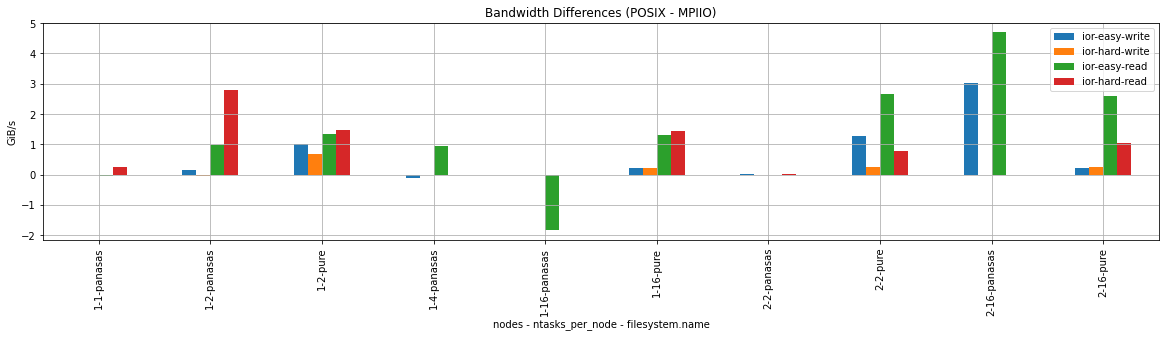

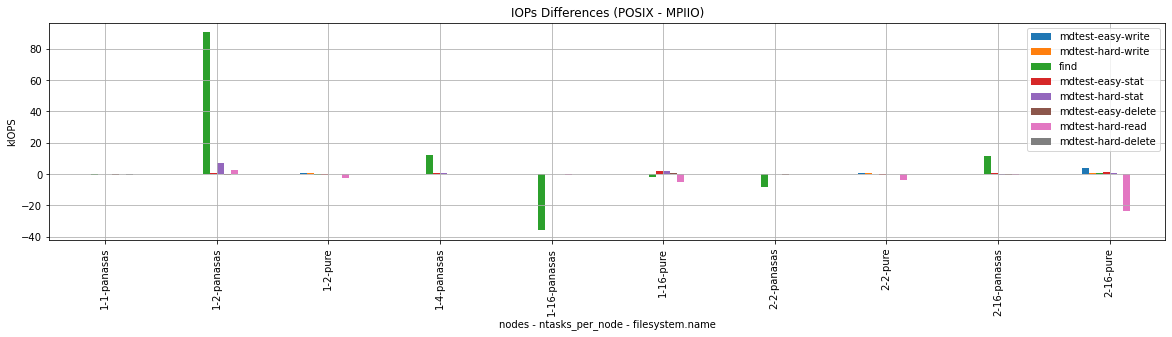

In [7]:

# separate data into posix/mpiio:
posix_mins = mins.loc[mins['ior_api'] == 'POSIX']
mpiio_mins = mins.loc[mins['ior_api'] == 'MPIIO']

# merge dataframes on relevant description columns:
api_match_ignore = ['iters', 'ior_api'] # have to omit iters, as that's already gone from the mins and maxs dfs
api_match_cols = [d for d in descr_cols if d not in api_match_ignore]
merged = pd.merge(posix_mins, mpiio_mins, on=api_match_cols, suffixes=('_posix', '_mpiio'))

# change colums to contain the DELTA between matching POSIX/MPIIO rows:
for col in result_cols:
    merged[col] = merged[col+'_posix'] - merged[col+'_mpiio']
    merged.drop(col+'_posix', axis='columns', inplace=True)
    merged.drop(col+'_mpiio', axis='columns', inplace=True)
merged.drop(['ior_api_posix', 'ior_api_mpiio'], axis='columns', inplace=True)

# change to a the indexmulti level index to allow easy grouped plotting:
merged.set_index(api_match_cols, inplace=True)

# create a set of labels from the multi-index:
plot_index = merged.index.droplevel(['filesystem.mountpoint', 'stonewall', 'time'])
xlabels = ['-'.join(map(str, v)) for v in plot_index.tolist()] # i.e. the '-'-separated values of the bits of the index/description columns of interest
xlabel = ' - '.join(plot_index.names) # i.e. what those '-'-separated parts are

# create separate Bandwidth and IOPs plots:
merged_bw = merged[bw_cols]
merged_iops = merged[iops_cols]
bw_ax = merged_bw.plot.bar(y=bw_cols, figsize=(20, 4), grid=True,xlabel=xlabel, ylabel=bw_unit, title='Bandwidth Differences (POSIX - MPIIO)')
iops_ax= merged_iops.plot.bar(y=iops_cols, figsize=(20, 4), grid=True,xlabel=xlabel, ylabel=iops_unit, title='IOPs Differences (POSIX - MPIIO)')
bw_ax.set_xticklabels(xlabels)
iops_ax.set_xticklabels(xlabels)
